In [7]:
using Trixi
using OrdinaryDiffEq

gamma_gas = 1.4
equations = CompressibleEulerEquations1D(gamma_gas)

###############################################################################
# setup the GSBP DG discretization that uses the Gauss operators from 
# Chan, Del Rey Fernandez, Carpenter (2019). 
# [https://doi.org/10.1137/18M1209234](https://doi.org/10.1137/18M1209234)

# Shu-Osher initial condition for 1D compressible Euler equations
# Example 8 from Shu, Osher (1989).
# [https://doi.org/10.1016/0021-9991(89)90222-2](https://doi.org/10.1016/0021-9991(89)90222-2)
function initial_condition_shu_osher(x, t, equations::CompressibleEulerEquations1D)
    x0 = -4

    rho_left = 27 / 7
    v_left = 4 * sqrt(35) / 9
    p_left = 31 / 3

    # Replaced v_right = 0 to v_right = 0.1 to avoid positivity issues.
    v_right = 0.1
    p_right = 1.0

    rho = ifelse(x[1] > x0, 1 + 1 / 5 * sin(5 * x[1]), rho_left)
    v = ifelse(x[1] > x0, v_right, v_left)
    p = ifelse(x[1] > x0, p_right, p_left)

    return prim2cons(SVector(rho, v, p),
                     equations)
end

initial_condition = initial_condition_shu_osher

surface_flux = flux_lax_friedrichs
volume_flux = flux_ranocha

polydeg = 3
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = density_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)

dg = DGMulti(basis,
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = volume_integral)

boundary_condition = BoundaryConditionDirichlet(initial_condition)
boundary_conditions = (; :entire_boundary => boundary_condition)

###############################################################################
#  setup the 1D mesh

cells_per_dimension = (64,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-5.0,), coordinates_max = (5.0,),
                   periodicity = false)

###############################################################################
#  setup the semidiscretization and ODE problem

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition,
                                    dg, boundary_conditions = boundary_conditions)

tspan = (0.0, 1.0)
ode = semidiscretize(semi, tspan)

###############################################################################
#  setup the callbacks

# prints a summary of the simulation setup and resets the timers
summary_callback = SummaryCallback()

# analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100, uEltype = real(dg))

# handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.1)

# collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback, analysis_callback, stepsize_callback)

# ###############################################################################
# # run the simulation

sol = solve(ode, SSPRK43(), dt = 0.1, callback = callbacks, save_everystep = false)


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 1.                         │
│ equations: …………………………………………………… CompressibleEulerEquations1D                                     │
│ initial condition: ……………………………… initial_condition_shu_osher                                      │
│ boundary conditions: ………………………… 1                                                                

LoadError: DomainError with -0.2202385706076428:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [9]:
analysis_callback(sol)

(l2 = [1.673813320412685, 5.980737909458242, 21.587822949251173], linf = [3.1388039126918064, 10.630952212105246, 37.682826521024865])

In [19]:
analysis_callback(sol)

(l2 = [1.7174961130340436, 6.1996479354864675, 22.312258445333125], linf = [3.2780380820176305, 11.086942738572729, 39.18585536351379])

In [6]:
Trixi.@trixi_testset "elixir_euler_shu_osher_gauss_shock_capturing.jl " begin
    @test_trixi_include(joinpath(EXAMPLES_DIR, "elixir_euler_shu_osher_gauss_shock_capturing.jl"),
                        cells_per_dimension=(64,), tspan=(0.0, 0.1),
                        # division by sqrt(2.0) corresponds to normalization by the square root of the size of the domain
                        l2=[
                            7.853842541289665e-7,
                            9.609905503440606e-7,
                            2.832322219966481e-6,
                        ] ./ sqrt(2.0),
                        linf=[
                            1.5003758788711963e-6,
                            1.802998748523521e-6,
                            4.83599270806323e-6,
                        ])
    # Ensure that we do not have excessive memory allocations
    # (e.g., from type instabilities)
    let
        t = sol.t[end]
        u_ode = sol.u[end]
        du_ode = similar(u_ode)
        @test (@allocated Trixi.rhs!(du_ode, u_ode, semi, t)) < 1000
    end
end

LoadError: LoadError: UndefVarError: `@trixi_testset` not defined
in expression starting at In[6]:1

In [6]:
using CairoMakie
using LaTeXStrings
# using Plots

In [7]:
# # Plot initial condition
# Nx = 200
# xgrid = -1 .+ 2*collect(0:Nx)./Nx

# ρvp = map(x-> initial_condition_shu_osher(x, 0.0, equations), xgrid)

# fig = Figure(size = (800, 400))

# label_tab = [L"\rho", L"v", L"p"]
# for i=1:3
#     axi = Axis(fig[1,i], xgridvisible = false, ygridvisible = false, 
#           xlabel = L"x", ylabel = latexstring(label_tab[i]))
#     lines!(axi, xgrid, Matrix(hcat(ρvp...))[i,:], label = latexstring(label_tab[i]))
#     axislegend(axi)
#     xlims!(axi, -1, 1)
# end

# resize_to_layout!(fig)

# fig

In [80]:
using Trixi
using OrdinaryDiffEq

# # Rescaled Shu-Osher initial condition to lie between [-1, 1]
# function initial_condition_shu_osher(x, t, equations::CompressibleEulerEquations1D)
#     x0 = -1 + 1/5
    
#     rho_left = 27/7
#     v_left = 4*sqrt(35)/9
#     p_left = 31/3
    
#     v_right = 0.0
#     p_right = 1.0
    
#     rho = ifelse(x[1] > x0, 1 + 1/5*sin(25*x[1]), rho_left)
#     v = ifelse(x[1] > x0, v_right, v_left)
#     p = ifelse(x[1] > x0, p_right, p_left)

#     return prim2cons(SVector(rho, v, p), equations)
# end

function initial_condition_shu_osher(x, t, equations::CompressibleEulerEquations1D)
    x0 = -4
    
    rho_left = 27/7
    v_left = 4*sqrt(35)/9
    p_left = 31/3
    
    v_right = 0.1
    p_right = 1.0
    
    rho = ifelse(x[1] > x0, 1 + 1/5*sin(5*x[1]), rho_left)
    v = ifelse(x[1] > x0, v_right, v_left)
    p = ifelse(x[1] > x0, p_right, p_left)

    return prim2cons(SVector(rho + 0.1*rand(), v + 0.1*rand(), p + 0.1*rand()), equations)
end


equations = CompressibleEulerEquations1D(1.4)

surface_flux = flux_lax_friedrichs
volume_flux = flux_ranocha

initial_condition = initial_condition_shu_osher

boundary_condition = BoundaryConditionDirichlet(initial_condition)
# boundary_conditions = Dict(:all => boundary_condition)
boundary_conditions = (; :entire_boundary => boundary_condition)

polydeg = 3
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = density_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)

dg = DGMulti(basis,
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = volume_integral)



cells_per_dimension = (100,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-5.0,), coordinates_max = (5.0,), periodicity = false)

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, 
                                    dg, boundary_conditions = boundary_conditions)

tspan = (0, 2)

ode = semidiscretize(semi, tspan)

stepsize_callback = StepsizeCallback(; cfl=0.1)
callbacks = CallbackSet(stepsize_callback)

stage_limiter! = PositivityPreservingLimiterZhangShu(thresholds=(5.0e-6, 5.0e-6),
                                                     variables=(Trixi.density, pressure))

sol = solve(ode, SSPRK43(), adaptive = true, callback = callbacks, save_everystep = true)
#             dt = 1.0, 

retcode: Success
Interpolation: 3rd order Hermite
t: 1780-element Vector{Float64}:
 0.0
 0.00012538277089129007
 0.0001627833683262603
 0.00019627232150601646
 0.00022567191586103343
 0.0002553665101261518
 0.0002872061729732588
 0.0003242019575944867
 0.000405857743532088
 0.0004702795359070245
 0.0005729022938630563
 0.0006689221279466758
 0.0008040303898680645
 ⋮
 1.9869946574491453
 1.9881964927445375
 1.9894431240062092
 1.9906192745701177
 1.9920159896909744
 1.993370187704825
 1.9945637432831043
 1.9956325918033009
 1.996716791045242
 1.997779981945467
 1.998946665839094
 2.0
u: 1780-element Vector{StructArray{SVector{3, Float64}, 2, Tuple{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}, Int64}}:
 [[3.965236252617825, 10.743987685984207, 40.49849585491257] [3.952120895564178, 10.758203659104723, 40.694150387581054] … [0.8281138291515818, 0.13690892378032596, 2.6230023245786263] [0.9117219995936121, 0.12148694811127012, 2.6239734831883115]; [3.9318635456106446, 10.597656427071

In [87]:
X = Vector{Float64}[]#sol(1.0)
for (i, xi) in enumerate(sol(2.0))
    push!(X, Vector(xi))
end

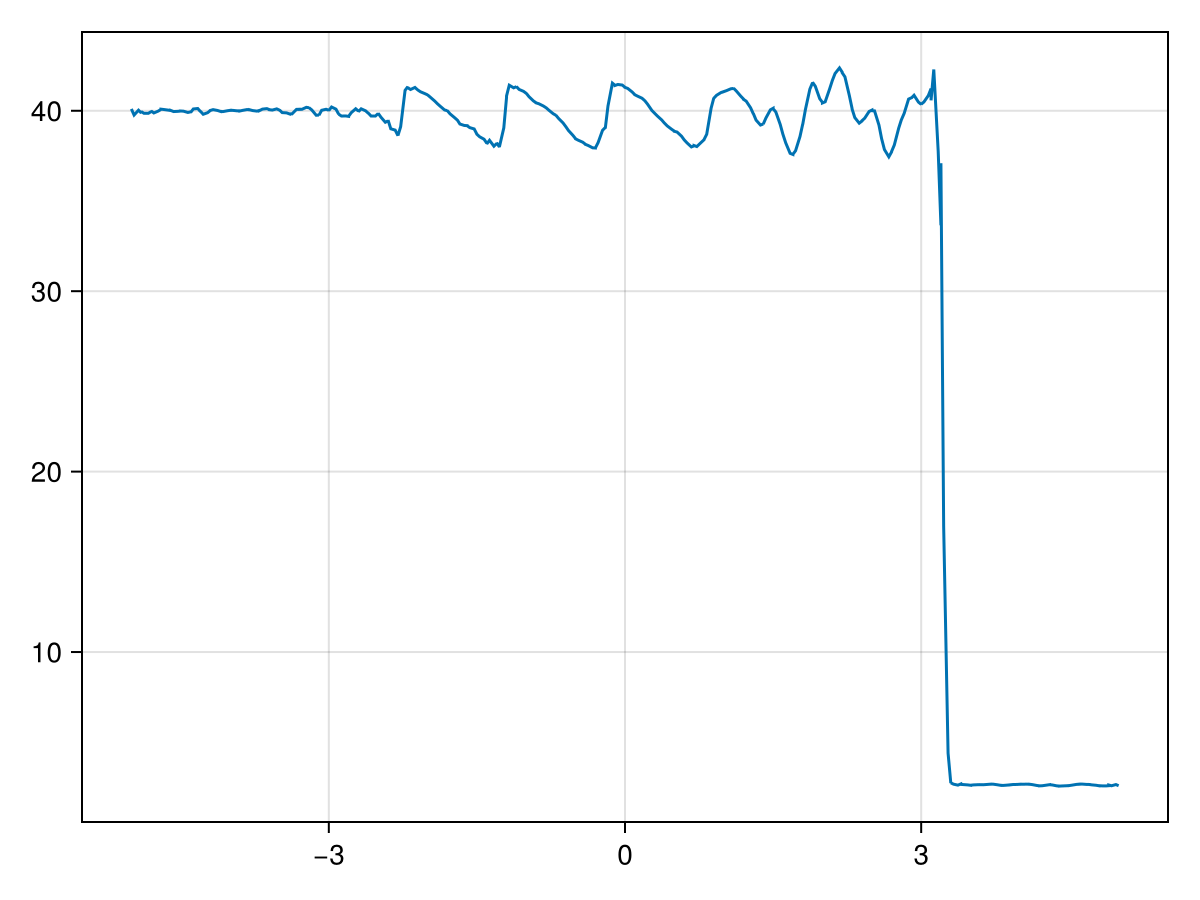

In [89]:
lines(vec(mesh.md.x), hcat(X...)[3,:])

In [90]:
equations = CompressibleEulerEquations1D(1.4)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ CompressibleEulerEquations1D                                                                     │
│ ════════════════════════════                                                                     │
│ #variables: ………………………………………………… 3                                                                │
│ │ variable 1: …………………………………………… rho                                                              │
│ │ variable 2: …………………………………………… rho_v1                                                           │
│ │ variable 3: …………………………………………… rho_e                                                            │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [91]:
surface_flux = flux_lax_friedrichs
volume_flux = flux_shima_etal

polydeg = 3
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = density_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)

dg = DGMulti(basis,
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = volume_integral)



┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… RefElemData{N=3, Polynomial{Gauss}, Line}.                       │
│ mortar: …………………………………………………………… nothing                                                          │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralShockCapturingHG                                   │
│ │ volume flux DG: ………………………………… flux_shima_etal                                                  │
│ │ volume flux FV: ………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                   

In [92]:
initial_condition = initial_condition_shu_osher

initial_condition_shu_osher (generic function with 1 method)

In [93]:
cells_per_dimension = (8,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-1.0,), coordinates_max = (1.0,), periodicity = true)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DGMultiMesh{1, Trixi.Affine},                                                                    │
│ ══════════════════════════════                                                                   │
│ number of elements: …………………………… 8                                                                │
│ number of boundaries: ……………………… 1                                                                │
│ │ nfaces on entire_boundary: …… 0                                                                │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [94]:
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, dg)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 1.                         │
│ equations: …………………………………………………… CompressibleEulerEquations1D                                     │
│ initial condition: ……………………………… initial_condition_shu_osher                                      │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

In [95]:
tspan = (0, 2)

ode = semidiscretize(semi, tspan)

ODEProblem with uType StructArray{SVector{3, Float64}, 2, Tuple{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}, Int64} and tType Int64. In-place: true
timespan: (0, 2)
u0: 4×8 StructArray(::Matrix{Float64}, ::Matrix{Float64}, ::Matrix{Float64}) with eltype SVector{3, Float64}:
 [1.23749, 0.138594, 2.78002]  …  [0.920083, 0.0664401, 2.73098]
 [1.217, 0.189595, 2.60133]       [0.924203, 0.167211, 2.72973]
 [1.2242, 0.232122, 2.60518]      [0.839143, 0.145044, 2.55451]
 [1.14896, 0.181756, 2.79692]     [0.899226, 0.195238, 2.62173]

In [55]:
sol = solve(ode, CarpenterKennedy2N54(williamson_condition = false),
            dt = 0.5 * estimate_dt(mesh, dg), save_everystep = true)#, callback = callbacks);

LoadError: MethodError: no method matching flux_shima_etal(::SVector{3, Float64}, ::SVector{3, Float64}, ::SVector{1, Float64}, ::CompressibleEulerEquations1D{Float64})

[0mClosest candidates are:
[0m  flux_shima_etal(::Any, ::Any, ::AbstractVector, [91m::CompressibleEulerEquations3D[39m)
[0m[90m   @[39m [36mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/equations/[39m[90m[4mcompressible_euler_3d.jl:485[24m[39m
[0m  flux_shima_etal(::Any, ::Any, ::AbstractVector, [91m::CompressibleEulerEquations2D[39m)
[0m[90m   @[39m [36mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/equations/[39m[90m[4mcompressible_euler_2d.jl:461[24m[39m
[0m  flux_shima_etal(::Any, ::Any, [91m::Integer[39m, ::CompressibleEulerEquations1D)
[0m[90m   @[39m [36mTrixi[39m [90m~/.julia/packages/Trixi/kZ2a3/src/equations/[39m[90m[4mcompressible_euler_1d.jl:279[24m[39m
[0m  ...


In [42]:
using Trixi, OrdinaryDiffEq

surface_flux = FluxLaxFriedrichs()
volume_flux = flux_ranocha

polydeg = 4
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

dg = DGMulti(polydeg = 3, element_type = Line(), approximation_type = GaussSBP(),
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = VolumeIntegralFluxDifferencing(volume_flux))

equations = CompressibleEulerEquations1D(1.4)

initial_condition = initial_condition_shu_osher
# source_terms = source_terms_convergence_test

cells_per_dimension = (8,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-1.0,), coordinates_max = (1.0,), periodicity = false)
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, dg)

tspan = (0.0, 1.1)
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()
alive_callback = AliveCallback(alive_interval = 10)
analysis_interval = 100
analysis_callback = AnalysisCallback(semi, interval = analysis_interval, uEltype = real(dg))
callbacks = CallbackSet(summary_callback,
                        analysis_callback,
                        alive_callback)

###############################################################################
# run the simulation

sol = solve(ode, CarpenterKennedy2N54(williamson_condition = false),
            dt = 0.5 * estimate_dt(mesh, dg), save_everystep = false, callback = callbacks);

summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 1.                         │
│ equations: …………………………………………………… CompressibleEulerEquations1D                                     │
│ initial condition: ……………………………… initial_condition_shu_osher                                      │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

LoadError: DomainError with -0.40686060842446015:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [10]:
using OrdinaryDiffEq
using Trixi

###############################################################################
# semidiscretization of the compressible Euler equations

equations = CompressibleEulerEquations1D(1.4)

"""
    initial_condition_sedov_blast_wave(x, t, equations::CompressibleEulerEquations1D)

The Sedov blast wave setup based on Flash
- https://flash.rochester.edu/site/flashcode/user_support/flash_ug_devel/node187.html#SECTION010114000000000000000
"""
function initial_condition_sedov_blast_wave(x, t, equations::CompressibleEulerEquations1D)
    # Set up polar coordinates
    inicenter = SVector(0.0)
    x_norm = x[1] - inicenter[1]
    r = abs(x_norm)

    # Setup based on https://flash.rochester.edu/site/flashcode/user_support/flash_ug_devel/node187.html#SECTION010114000000000000000
    r0 = 0.21875 # = 3.5 * smallest dx (for domain length=4 and max-ref=6)
    # r0 = 0.5 # = more reasonable setup
    E = 1.0
    p0_inner = 6 * (equations.gamma - 1) * E / (3 * pi * r0)
    p0_outer = 1.0e-5 # = true Sedov setup
    # p0_outer = 1.0e-3 # = more reasonable setup

    # Calculate primitive variables
    rho = 1.0
    v1 = 0.0
    p = r > r0 ? p0_outer : p0_inner

    return prim2cons(SVector(rho, v1, p), equations)
end
initial_condition = initial_condition_sedov_blast_wave

surface_flux = flux_lax_friedrichs
volume_flux = flux_ranocha
basis = LobattoLegendreBasis(3)
indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = density_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)
solver = DGSEM(basis, surface_flux, volume_integral)

coordinates_min = (-2.0,)
coordinates_max = (2.0,)
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 6,
                n_cells_max = 10_000)

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

###############################################################################
# ODE solvers, callbacks etc.

tspan = (0.0, 4.0)
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()

analysis_interval = 500
analysis_callback = AnalysisCallback(semi, interval = analysis_interval)

alive_callback = AliveCallback(analysis_interval = analysis_interval)

save_solution = SaveSolutionCallback(interval = 100,
                                     save_initial_solution = true,
                                     save_final_solution = true,
                                     solution_variables = cons2prim)

amr_indicator = IndicatorLöhner(semi,
                                variable = density_pressure)
amr_controller = ControllerThreeLevel(semi, amr_indicator,
                                      base_level = 4,
                                      med_level = 0, med_threshold = 0.1, # med_level = current level
                                      max_level = 6, max_threshold = 0.3)
amr_callback = AMRCallback(semi, amr_controller,
                           interval = 2,
                           adapt_initial_condition = true,
                           adapt_initial_condition_only_refine = true)

stepsize_callback = StepsizeCallback(cfl = 0.5)

callbacks = CallbackSet(summary_callback,
                        analysis_callback, alive_callback,
                        save_solution,
                        amr_callback, stepsize_callback)

stage_limiter! = PositivityPreservingLimiterZhangShu(thresholds = (5.0e-6, 5.0e-6),
                                                     variables = (Trixi.density, pressure))

###############################################################################
# run the simulation

sol = solve(ode, CarpenterKennedy2N54(stage_limiter!, williamson_condition = false),
            dt = 1.0, # solve needs some value here but it will be overwritten by the stepsize_callback
            save_everystep = false, callback = callbacks);
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 127                 │
│ equations: …………………………………………………… CompressibleEulerEquations1D                                     │
│ initial condition: ……………………………… initial_condition_sedov_blast_wave                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

#timesteps:     50 │ Δt: 4.3245e-03 │ sim. time: 2.3008e-01 (5.752%)   │ run time: 1.8926e-01 s
#timesteps:    100 │ Δt: 4.9184e-03 │ sim. time: 4.5824e-01 (11.456%)  │ run time: 1.9109e-01 s
#timesteps:    150 │ Δt: 6.0358e-03 │ sim. time: 7.3309e-01 (18.327%)  │ run time: 1.9355e-01 s
#timesteps:    200 │ Δt: 7.1612e-03 │ sim. time: 1.0656e+00 (26.640%)  │ run time: 1.9505e-01 s
#timesteps:    250 │ Δt: 9.7649e-03 │ sim. time: 1.5094e+00 (37.736%)  │ run time: 1.9719e-01 s
#timesteps:    300 │ Δt: 1.0851e-02 │ sim. time: 2.0261e+00 (50.654%)  │ run time: 1.9878e-01 s
#timesteps:    350 │ Δt: 1.1952e-02 │ sim. time: 2.5978e+00 (64.944%)  │ run time: 2.0082e-01 s
#timesteps:    400 │ Δt: 1.3150e-02 │ sim. time: 3.2537e+00 (81.342%)  │ run time: 2.0204e-01 s
#timesteps:    450 │ Δt: 1.1663e-02 │ sim. time: 3.9177e+00 (97.943%)  │ run time: 2.0436e-01 s

────────────────────────────────────────────────────────────────────────────────────────────────────
 Simulation running 'CompressibleE

In [15]:
###############################################################################
# semidiscretization of the compressible Euler equations
equations = CompressibleEulerEquations1D(1.4)

initial_condition = initial_condition_weak_blast_wave

volume_flux = flux_ranocha
solver = DGSEM(polydeg = 3, surface_flux = flux_ranocha,
               volume_integral = VolumeIntegralFluxDifferencing(volume_flux))

coordinates_min = (-2.0,)
coordinates_max = (2.0,)
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 5,
                n_cells_max = 10_000)

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

###############################################################################
# ODE solvers, callbacks etc.

tspan = (0.0, 0.4)
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()

analysis_interval = 100
analysis_callback = AnalysisCallback(semi, interval = analysis_interval)

alive_callback = AliveCallback(analysis_interval = analysis_interval)

save_solution = SaveSolutionCallback(interval = 100,
                                     save_initial_solution = true,
                                     save_final_solution = true,
                                     solution_variables = cons2prim)

stepsize_callback = StepsizeCallback(cfl = 0.8)

callbacks = CallbackSet(summary_callback,
                        analysis_callback, alive_callback,
                        save_solution,
                        stepsize_callback)

###############################################################################
# run the simulation

sol = solve(ode, CarpenterKennedy2N54(williamson_condition = false),
            dt = 1.0, # solve needs some value here but it will be overwritten by the stepsize_callback
            save_everystep = false, callback = callbacks);
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 63                  │
│ equations: …………………………………………………… CompressibleEulerEquations1D                                     │
│ initial condition: ……………………………… initial_condition_weak_blast_wave                                │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

   get node variables       2   0.00ns    0.0%  0.00ns     0.00B    0.0%    0.00B
 analyze solution           2   1.38ms   42.6%   691μs   46.6KiB   45.4%  23.3KiB
 rhs!                     121    416μs   12.8%  3.44μs   6.61KiB    6.4%    55.9B
   volume integral        121    274μs    8.4%  2.26μs     0.00B    0.0%    0.00B
   interface flux         121   52.8μs    1.6%   437ns     0.00B    0.0%    0.00B
   ~rhs!~                 121   45.5μs    1.4%   376ns   6.61KiB    6.4%    55.9B
   prolong2interfaces     121   13.9μs    0.4%   115ns     0.00B    0.0%    0.00B
   surface integral       121   10.9μs    0.3%  90.2ns     0.00B    0.0%    0.00B
   Jacobian               121   9.67μs    0.3%  79.9ns     0.00B    0.0%    0.00B
   reset ∂u/∂t            121   5.50μs    0.2%  45.5ns     0.00B    0.0%    0.00B
   prolong2boundaries     121   2.08μs    0.1%  17.2ns     0.00B    0.0%    0.00B
   source terms           121   1.08μs    0.0%  8.96ns     0.00B    0.0%    0.00B
   boundary flux

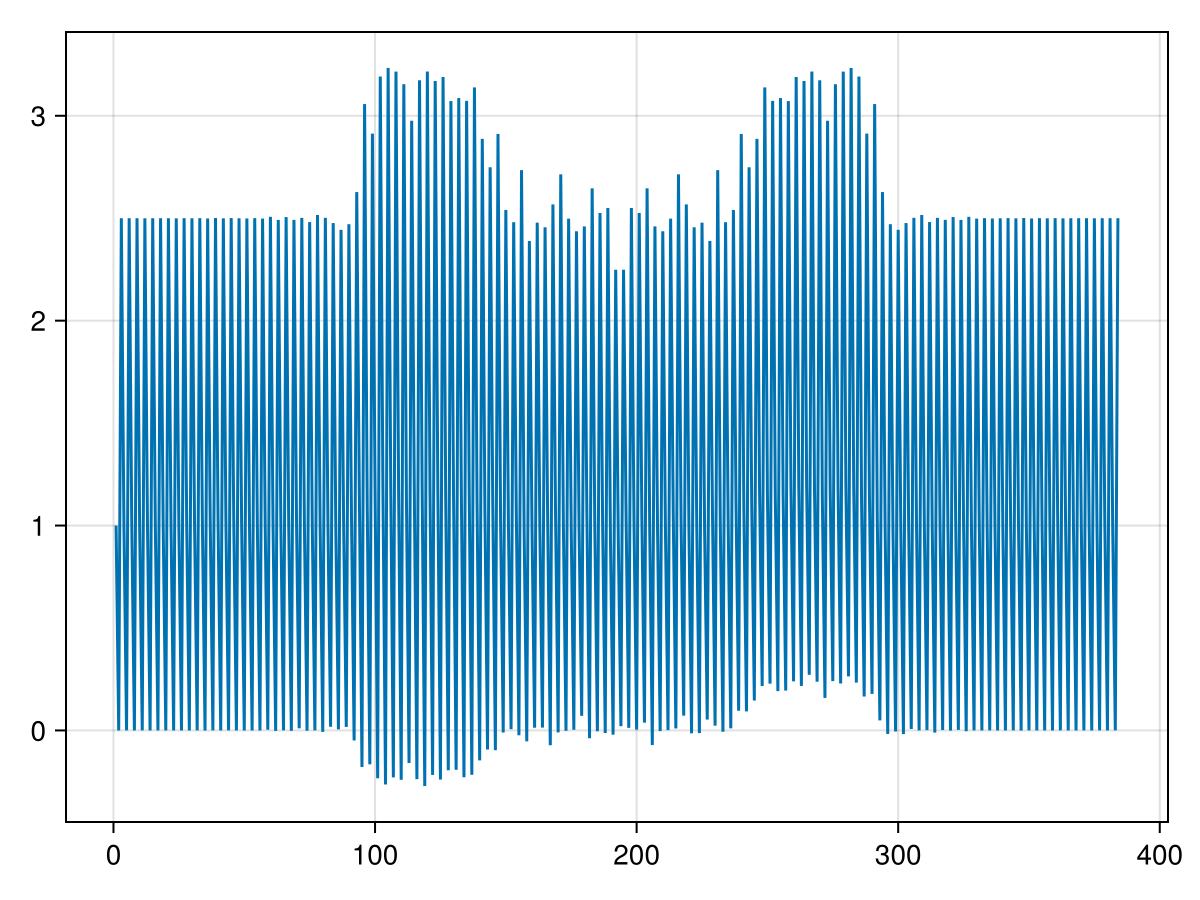

In [21]:
lines(sol(0.4))

In [77]:
using Trixi
using OrdinaryDiffEq

equations = InviscidBurgersEquation1D()

###############################################################################
# setup the GSBP DG discretization that uses the Gauss operators from 
# Chan, Del Rey Fernandez, Carpenter (2019). 
# [https://doi.org/10.1137/18M1209234](https://doi.org/10.1137/18M1209234)

surface_flux = flux_lax_friedrichs
volume_flux = flux_ec

polydeg = 4
basis = DGMultiBasis(Line(), polydeg, approximation_type = GaussSBP())

indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = first)

volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)

dg = DGMulti(basis,
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = volume_integral)

###############################################################################
#  setup the 1D mesh

cells_per_dimension = (64,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-1.0,), coordinates_max = (1.0,),
                   periodicity = true)

###############################################################################
#  setup the semidiscretization and ODE problem

semi = SemidiscretizationHyperbolic(mesh,
                                    equations,
                                    initial_condition_convergence_test,
                                    dg)

tspan = (0.0, 2.0)
ode = semidiscretize(semi, tspan)

###############################################################################
#  setup the callbacks

# prints a summary of the simulation setup and resets the timers
summary_callback = SummaryCallback()

# analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100, uEltype = real(dg))

# handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.5)

# collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback, analysis_callback, stepsize_callback)

# ###############################################################################
# # run the simulation

sol = solve(ode, SSPRK43(), #CarpenterKennedy2N54(williamson_condition = false),
            dt = 1.0, save_everystep = false, callback = callbacks);


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 1.                         │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  



────────────────────────────────────────────────────────────────────────────────────────────────────
 Simulation running 'InviscidBurgersEquation1D' with DGMulti(polydeg=4)
────────────────────────────────────────────────────────────────────────────────────────────────────
 #timesteps:                600                run time:       7.85953340e-02 s
 Δt:             1.21214083e-03                └── GC time:    0.00000000e+00 s (0.000%)
 sim. time:      7.68968609e-01 (38.448%)      time/DOF/rhs!:  8.56024866e-08 s
                                               PID:            8.89121429e-08 s
 #DOFs per field:           320                alloc'd memory:        411.245 MiB
 #elements:                  64

 Variable:       scalar        
 L2 error:       7.43254761e-01
 Linf error:     1.47920701e+00
 ∑∂S/∂U ⋅ Uₜ :  -1.07980076e-01
────────────────────────────────────────────────────────────────────────────────────────────────────


─────────────────────────────────────────────────

In [16]:
lines(vec(mesh.md.x), map(x-> x[1], vec(sol(2.0))))

LoadError: type TreeMesh has no field md

In [43]:

using OrdinaryDiffEq
using Trixi

###############################################################################
# semidiscretization of the compressible Euler equations

equations = CompressibleEulerEquations1D(1.4)

"""
    initial_condition_sedov_blast_wave(x, t, equations::CompressibleEulerEquations1D)

The Sedov blast wave setup based on Flash
- https://flash.rochester.edu/site/flashcode/user_support/flash_ug_devel/node187.html#SECTION010114000000000000000
"""
function initial_condition_sedov_blast_wave(x, t, equations::CompressibleEulerEquations1D)
    # Set up polar coordinates
    inicenter = SVector(0.0)
    x_norm = x[1] - inicenter[1]
    r = abs(x_norm)

    # Setup based on https://flash.rochester.edu/site/flashcode/user_support/flash_ug_devel/node187.html#SECTION010114000000000000000
    r0 = 0.21875 # = 3.5 * smallest dx (for domain length=4 and max-ref=6)
    # r0 = 0.5 # = more reasonable setup
    E = 1.0
    p0_inner = 6 * (equations.gamma - 1) * E / (3 * pi * r0)
    p0_outer = 1.0e-5 # = true Sedov setup
    # p0_outer = 1.0e-3 # = more reasonable setup

    # Calculate primitive variables
    rho = 1.0
    v1 = 0.0
    p = r > r0 ? p0_outer : p0_inner

    return prim2cons(SVector(rho, v1, p), equations)
end
initial_condition = initial_condition_sedov_blast_wave

surface_flux = flux_lax_friedrichs
volume_flux = flux_ranocha
basis = LobattoLegendreBasis(3)
indicator_sc = IndicatorHennemannGassner(equations, basis,
                                         alpha_max = 0.5,
                                         alpha_min = 0.001,
                                         alpha_smooth = true,
                                         variable = density_pressure)
volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
                                                 volume_flux_dg = volume_flux,
                                                 volume_flux_fv = surface_flux)
solver = DGSEM(basis, surface_flux, volume_integral)

coordinates_min = (-2.0,)
coordinates_max = (2.0,)
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 6,
                n_cells_max = 10_000)

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

###############################################################################
# ODE solvers, callbacks etc.

tspan = (0.0, 4.0)
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()

analysis_interval = 500
analysis_callback = AnalysisCallback(semi, interval = analysis_interval)

alive_callback = AliveCallback(analysis_interval = analysis_interval)

save_solution = SaveSolutionCallback(interval = 100,
                                     save_initial_solution = true,
                                     save_final_solution = true,
                                     solution_variables = cons2prim)

amr_indicator = IndicatorLöhner(semi,
                                variable = density_pressure)
amr_controller = ControllerThreeLevel(semi, amr_indicator,
                                      base_level = 4,
                                      med_level = 0, med_threshold = 0.1, # med_level = current level
                                      max_level = 6, max_threshold = 0.3)
amr_callback = AMRCallback(semi, amr_controller,
                           interval = 2,
                           adapt_initial_condition = true,
                           adapt_initial_condition_only_refine = true)

stepsize_callback = StepsizeCallback(cfl = 0.5)

callbacks = CallbackSet(summary_callback,
                        analysis_callback, alive_callback,
                        save_solution,
                        amr_callback, stepsize_callback)

stage_limiter! = PositivityPreservingLimiterZhangShu(thresholds = (5.0e-6, 5.0e-6),
                                                     variables = (Trixi.density, pressure))

###############################################################################
# run the simulation

sol = solve(ode, CarpenterKennedy2N54(stage_limiter!, williamson_condition = false),
            dt = 1.0, # solve needs some value here but it will be overwritten by the stepsize_callback
            save_everystep = true, callback = callbacks);
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 127                 │
│ equations: …………………………………………………… CompressibleEulerEquations1D                                     │
│ initial condition: ……………………………… initial_condition_sedov_blast_wave                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

#timesteps:    400 │ Δt: 1.3150e-02 │ sim. time: 3.2537e+00 (81.342%)  │ run time: 3.4070e-02 s
#timesteps:    450 │ Δt: 1.1663e-02 │ sim. time: 3.9177e+00 (97.943%)  │ run time: 3.6084e-02 s

────────────────────────────────────────────────────────────────────────────────────────────────────
 Simulation running 'CompressibleEulerEquations1D' with DGSEM(polydeg=3)
────────────────────────────────────────────────────────────────────────────────────────────────────
 #timesteps:                458                run time:       3.71966250e-02 s
 Δt:             2.68491124e-03                └── GC time:    0.00000000e+00 s (0.000%)
 sim. time:      4.00000000e+00 (100.000%)     time/DOF/rhs!:  5.12374655e-08 s
                                               PID:            1.65595332e-07 s
 #DOFs per field:            96                alloc'd memory:        282.387 MiB
 #elements:                  24
 ├── level 6:                 4
 ├── level 5:                10
 └── level 4:            

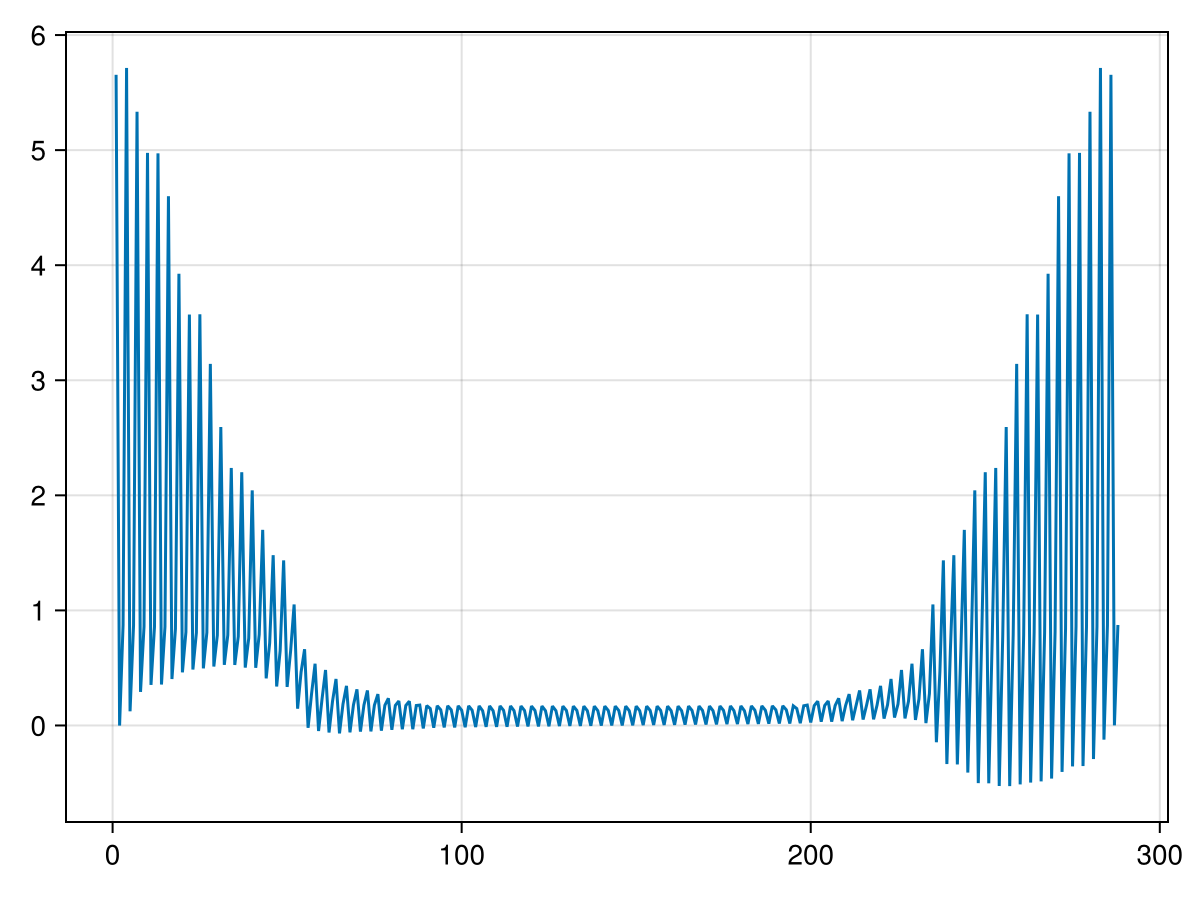

In [49]:
lines(sol.u[end])